<font size="+3"><strong>4.5. Earthquake Damage in Kavrepalanchok 🇳🇵</strong></font>

In this assignment, you'll build a classification model to predict building damage for the district of [Kavrepalanchok](https://en.wikipedia.org/wiki/Kavrepalanchok_District).

In [1]:
import warnings

import wqet_grader

warnings.simplefilter(action="ignore", category=FutureWarning)
wqet_grader.init("Project 4 Assessment")

In [2]:
# Import libraries here
import sqlite3
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

# Prepare Data

## Connect

Run the cell below to connect to the `nepal.sqlite` database.

In [3]:
%load_ext sql
%sql sqlite:////home/jovyan/nepal.sqlite

'Connected: @/home/jovyan/nepal.sqlite'

<div class="alert alert-block alert-warning">
<b>Warning:</b>Be careful with your SQL queries in this assignment. If you try to get all the rows from a table (for example, <code>SELECT * FROM id_map</code>), you will cause an Out of Memory error on your virtual machine. So always include a <code>LIMIT</code> when first exploring a database.
</div>

**Task 4.5.1:** What districts are represented in the `id_map` table? Determine the unique values in the **`district_id`** column.

In [4]:
%%sql

SELECT DISTINCT(district_id) FROM id_map

 * sqlite:////home/jovyan/nepal.sqlite
Done.


district_id
1
2
3
4


In [5]:
result = _.DataFrame().squeeze()  # noqa F821

wqet_grader.grade("Project 4 Assessment", "Task 4.5.1", result)

What's the district ID for Kavrepalanchok? From the lessons, you already know that Gorkha is `4`; from the textbook, you know that Ramechhap is `2`. Of the remaining districts, Kavrepalanchok is the one with the largest number of observations in the `id_map` table.

**Task 4.5.2:** Calculate the number of observations in the `id_map` table associated with district `1`.

In [10]:
%%sql

SELECT COUNT(district_id) FROM id_map 
WHERE district_id = 1

 * sqlite:////home/jovyan/nepal.sqlite
Done.


COUNT(district_id)
36112


In [11]:
result = [_.DataFrame().astype(float).squeeze()]  # noqa F821
wqet_grader.grade("Project 4 Assessment", "Task 4.5.2", result)

**Task 4.5.3:** Calculate the number of observations in the `id_map` table associated with district `3`.

In [12]:
%%sql
SELECT COUNT(district_id) FROM id_map
WHERE district_id=3


 * sqlite:////home/jovyan/nepal.sqlite
Done.


COUNT(district_id)
82684


In [14]:
result = [_.DataFrame().astype(float).squeeze()]  # noqa F821
wqet_grader.grade("Project 4 Assessment", "Task 4.5.3", result)

**Task 4.5.4:** Join the unique building IDs from Kavrepalanchok in `id_map`, all the columns from  `building_structure`, and the **`damage_grade`** column from `building_damage`, limiting. Make sure you rename the **`building_id`** column in `id_map` as **`b_id`** and limit your results to the first five rows of the new table.

In [20]:
%%sql
SELECT DISTINCT(i.building_id) AS b_id,
    s.*,
    d.damage_grade
FROM id_map AS i
JOIN building_structure AS s ON i.building_id = s.building_id
JOIN building_damage AS d ON i.building_id = d.building_id
WHERE district_id = 3
LIMIT 5


 * sqlite:////home/jovyan/nepal.sqlite
Done.


b_id,building_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,superstructure,damage_grade
87473,87473,2,1,15,382,18,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",Grade 4
87479,87479,1,0,12,328,7,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Damaged-Rubble clear,"Stone, mud mortar",Grade 5
87482,87482,2,1,23,427,20,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Not used,"Stone, mud mortar",Grade 4
87491,87491,2,1,12,427,14,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Not used,"Stone, mud mortar",Grade 4
87496,87496,2,0,32,360,18,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Rubble clear,"Stone, mud mortar",Grade 5


In [21]:
result = _.DataFrame().set_index("b_id")  # noqa F821

wqet_grader.grade("Project 4 Assessment", "Task 4.5.4", result)

## Import

**Task 4.5.5:** Write a `wrangle` function that will use the query you created in the previous task to create a DataFrame. In addition your function should:

1. Create a `"severe_damage"` column, where all buildings with a damage grade greater than `3` should be encoded as `1`. All other buildings should be encoded at `0`. 
2. Drop any columns that could cause issues with leakage or multicollinearity in your model.

In [29]:
# Build your `wrangle` function here
def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT DISTINCT(i.building_id) AS b_id,
            s.*,
            d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 3
        
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")

    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]

    # Add high-cardinality / redundant column
    drop_cols.append("building_id")

    # Create binary target column
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

    # Drop old target
    drop_cols.append("damage_grade")

    # Drop multicollinearity column
    drop_cols.append("count_floors_pre_eq")

    # Drop columns
    df.drop(columns=drop_cols, inplace=True)

    return df

Use your `wrangle` function to query the database at `"/home/jovyan/nepal.sqlite"` and return  your cleaned results.

In [30]:
df = wrangle("/home/jovyan/nepal.sqlite")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
87473,15,382,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87479,12,328,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,"Stone, mud mortar",1
87482,23,427,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87491,12,427,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87496,32,360,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76533 entries, 87473 to 163998
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age_building            76533 non-null  int64 
 1   plinth_area_sq_ft       76533 non-null  int64 
 2   height_ft_pre_eq        76533 non-null  int64 
 3   land_surface_condition  76533 non-null  object
 4   foundation_type         76533 non-null  object
 5   roof_type               76533 non-null  object
 6   ground_floor_type       76533 non-null  object
 7   other_floor_type        76533 non-null  object
 8   position                76533 non-null  object
 9   plan_configuration      76533 non-null  object
 10  superstructure          76533 non-null  object
 11  severe_damage           76533 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 7.6+ MB


In [32]:

wqet_grader.grade(
    "Project 4 Assessment", "Task 4.5.5", wrangle("/home/jovyan/nepal.sqlite")
)

## Explore

**Task 4.5.6:** Are the classes in this dataset balanced? Create a bar chart with the normalized value counts from the `"severe_damage"` column. Be sure to label the x-axis `"Severe Damage"` and the y-axis `"Relative Frequency"`. Use the title `"Kavrepalanchok, Class Balance"`.

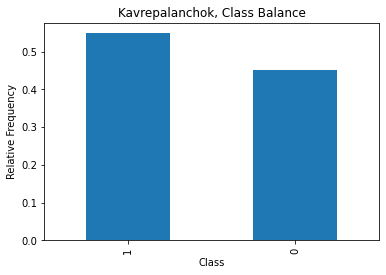

In [33]:
# Plot value counts of `"severe_damage"`
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Class", ylabel="Relative Frequency", title="Kavrepalanchok, Class Balance"
)
# Don't delete the code below 👇
plt.savefig("images/4-5-6.png", dpi=150)


In [34]:
with open("images/4-5-6.png", "rb") as file:
    wqet_grader.grade("Project 4 Assessment", "Task 4.5.6", file)

**Task 4.5.7:** Is there a relationship between the footprint size of a building and the damage it sustained in the earthquake? Use seaborn to create a boxplot that shows the distributions of the `"plinth_area_sq_ft"` column for both groups in the `"severe_damage"` column. Label your x-axis `"Severe Damage"` and y-axis `"Plinth Area [sq. ft.]"`. Use the title `"Kavrepalanchok, Plinth Area vs Building Damage"`. 

In [36]:
import seaborn as sns

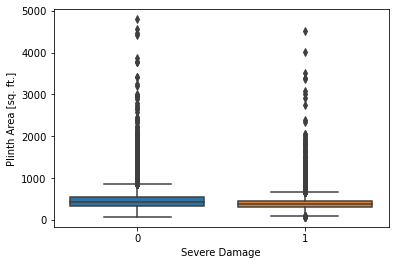

In [47]:
sns.boxplot(x="severe_damage", y="plinth_area_sq_ft", data=df).set(
    xlabel='Severe Damage', 
    ylabel='Plinth Area [sq. ft.]'
)


# Don't delete the code below 👇
plt.savefig("images/4-5-7.png", dpi=150)


In [48]:
with open("images/4-5-7.png", "rb") as file:
    wqet_grader.grade("Project 4 Assessment", "Task 4.5.7", file)

**Task 4.5.8:** Are buildings with certain roof types more likely to suffer severe damage? Create a pivot table of `df` where the index is `"roof_type"` and the values come from the `"severe_damage"` column, aggregated by the mean.

In [51]:
roof_pivot = pd.pivot_table(
    data=df, index="roof_type", values="severe_damage", aggfunc=np.mean
)
roof_pivot

,severe_damage
roof_type,
Bamboo/Timber-Heavy roof,0.569477
Bamboo/Timber-Light roof,0.604842
RCC/RB/RBC,0.040715


In [52]:

wqet_grader.grade("Project 4 Assessment", "Task 4.5.8", roof_pivot)

## Split

**Task 4.5.9:** Create your feature matrix `X` and target vector `y`. Your target is `"severe_damage"`. 

In [54]:
target="severe_damage"
X = df.drop(columns=target)
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (76533, 11)
y shape: (76533,)


In [55]:

wqet_grader.grade("Project 4 Assessment", "Task 4.5.9a", X)

In [57]:

wqet_grader.grade("Project 4 Assessment", "Task 4.5.9b", y)

**Task 4.5.10:** Divide your dataset into training and validation sets using a randomized split. Your validation set should be 20% of your data.

In [58]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=1, 
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (61226, 11)
y_train shape: (61226,)
X_val shape: (15307, 11)
y_val shape: (15307,)


In [59]:
wqet_grader.grade("Project 4 Assessment", "Task 4.5.10", [X_train.shape == (61226, 11)])

# Build Model

## Baseline

**Task 4.5.11:** Calculate the baseline accuracy score for your model.

In [60]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.55


In [61]:
wqet_grader.grade("Project 4 Assessment", "Task 4.5.11", [acc_baseline])

## Iterate

**Task 4.5.12:** Create a model `model_lr` that uses logistic regression to predict building damage. Be sure to include an appropriate encoder for categorical features. 

In [65]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=1000)

)
# Fit model to training data
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [66]:

wqet_grader.grade("Project 4 Assessment", "Task 4.5.12", model_lr)

**Task 4.5.13:** Calculate training and validation accuracy score for `model_lr`. 

In [68]:
lr_train_acc = accuracy_score(y_train, model_lr.predict(X_train))
lr_val_acc = model_lr.score(X_val, y_val)


print("Logistic Regression, Training Accuracy Score:", lr_train_acc)
print("Logistic Regression, Validation Accuracy Score:", lr_val_acc)

Logistic Regression, Training Accuracy Score: 0.6530885571489237
Logistic Regression, Validation Accuracy Score: 0.6482001698569282


In [69]:
submission = [lr_train_acc, lr_val_acc]
wqet_grader.grade("Project 4 Assessment", "Task 4.5.13", submission)

**Task 4.5.14:** Perhaps a decision tree model will perform better than logistic regression, but what's the best hyperparameter value for `max_depth`? Create a `for` loop to train and evaluate the model `model_dt` at all depths from 1 to 15. Be sure to use an appropriate encoder for your model, and to record its training and validation accuracy scores at every depth. The grader will evaluate your validation accuracy scores only.

In [73]:
from category_encoders import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [75]:
depth_hyperparams = range(1, 16)
training_acc = []
validation_acc = []
for d in depth_hyperparams:
    model_dt = make_pipeline(
        OrdinalEncoder(), DecisionTreeClassifier(max_depth = d, random_state=1)
    )
    model_dt.fit(X_train, y_train)
    training_acc.append(model_dt.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(model_dt.score(X_val, y_val))
    
print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

Training Accuracy Scores: [0.6428478097540261, 0.6493809819357789, 0.655538496717081]
Validation Accuracy Scores: [0.6400339713856406, 0.6411445743777356, 0.6467629189259816]


In [76]:
submission = pd.Series(validation_acc, index=depth_hyperparams)

wqet_grader.grade("Project 4 Assessment", "Task 4.5.14", submission)

**Task 4.5.15:** Using the values in `training_acc` and `validation_acc`, plot the validation curve for `model_dt`. Label your x-axis `"Max Depth"` and your y-axis `"Accuracy Score"`. Use the title `"Validation Curve, Decision Tree Model"`, and include a legend. 

In [87]:
print("Validation Accuracy Scores:", validation_acc)

Validation Accuracy Scores: [0.6400339713856406, 0.6411445743777356, 0.6467629189259816, 0.6470895668648331, 0.6511400013065918, 0.6544064806951068, 0.6579996080224734, 0.6608087802965963, 0.6610700986476775, 0.6581302671980139, 0.6588488926634873, 0.6584569151368654, 0.6598288364800418, 0.6585222447246358, 0.6538838439929444]


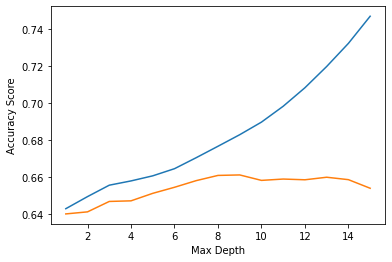

In [77]:

# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams, training_acc, label="training")
plt.plot(depth_hyperparams, validation_acc, label="validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")


# Don't delete the code below 👇
plt.savefig("images/4-5-15.png", dpi=150)


In [78]:
with open("images/4-5-15.png", "rb") as file:
    wqet_grader.grade("Project 4 Assessment", "Task 4.5.15", file)

**Task 4.5.16:** Build and train a new decision tree model `final_model_dt`, using the value for `max_depth` that yielded the best validation accuracy score in your plot above. 

In [105]:
final_model_dt = make_pipeline(
        OrdinalEncoder(), DecisionTreeClassifier(max_depth = 10, random_state=42)
)
final_model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
Building with Central Courtyard     8
U-shape                             9
H-shape                            10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                                          'data_type': dtype('O'),
                                          'mapping': Stone, mud mortar        1
Adobe/mud                2
RC, non-engineered       3
RC, engineered           4
Brick, mud mortar        5
Brick, cement mortar     6
Timber                   7
Other                    8
Stone, cement mortar     9
Stone                   10
Bamboo                  11
NaN                     -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])

In [106]:

wqet_grader.grade("Project 4 Assessment", "Task 4.5.16", final_model_dt)

In [107]:
X_train.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure
b_id,,,,,,,,,,,
101808,21,400,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,"Stone, mud mortar"
155600,36,720,16,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar"
89359,15,280,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar"
99199,7,550,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar"
91268,11,275,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,"Stone, mud mortar"


## Evaluate

**Task 4.5.17:** How does your model perform on the test set? First, read the CSV file `"data/kavrepalanchok-test-features.csv"` into the DataFrame `X_test`. Next, use `final_model_dt` to generate a list of test predictions `y_test_pred`. Finally, submit your test predictions to the grader to see how your model performs.

**Tip:** Make sure the order of the columns in `X_test` is the same as in your `X_train`. Otherwise, it could hurt your model's performance.

In [108]:
X_test = pd.read_csv("data/kavrepalanchok-test-features.csv", index_col="b_id")


In [109]:
X_test.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure
b_id,,,,,,,,,,,
316158,27,382,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Attached-1 side,Rectangular,"Stone, mud mortar"
316175,5,360,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar"
316192,11,450,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Attached-1 side,Rectangular,"Stone, mud mortar"
316202,40,360,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,TImber/Bamboo-Mud,Not attached,Square,"Stone, mud mortar"
316206,1,405,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,"Stone, mud mortar"


In [111]:
X_test = pd.read_csv("data/kavrepalanchok-test-features.csv", index_col="b_id")
y_test_pred = final_model_dt.predict(X_test)
y_test_pred[:5]

array([1, 1, 1, 1, 0])

In [113]:
submission = pd.Series(y_test_pred)
wqet_grader.grade("Project 4 Assessment", "Task 4.5.17", submission)

Exception: Could not grade submission: Could not verify access to this assessment: Received error from WQET submission API: You have already passed this course!

# Communicate Results

**Task 4.5.18:** What are the most important features for `final_model_dt`? Create a Series Gini `feat_imp`, where the index labels are the feature names for your dataset and the values are the feature importances for your model. Be sure that the Series is sorted from smallest to largest feature importance. 

In [116]:
features = X_test.columns
importances = final_model_dt.named_steps["decisiontreeclassifier"].feature_importances_

feat_imp = pd.Series(importances, index=features).sort_values(ascending=True)
feat_imp.head()

plan_configuration        0.002615
position                  0.013146
land_surface_condition    0.014244
ground_floor_type         0.015556
roof_type                 0.018341
dtype: float64

In [117]:

wqet_grader.grade("Project 4 Assessment", "Task 4.5.18", feat_imp)

Exception: Could not grade submission: Could not verify access to this assessment: Received error from WQET submission API: You have already passed this course!

**Task 4.5.19:** Create a horizontal bar chart of `feat_imp`. Label your x-axis `"Gini Importance"` and your y-axis `"Label"`. Use the title `"Kavrepalanchok Decision Tree, Feature Importance"`.

Do you see any relationship between this plot and the exploratory data analysis you did regarding roof type?

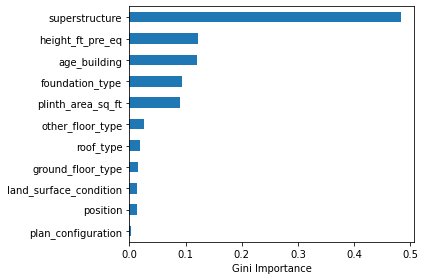

In [118]:
# Create horizontal bar chart of feature importances

feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance")

# Don't delete the code below 👇
plt.tight_layout()
plt.savefig("images/4-5-19.png", dpi=150)


In [119]:
with open("images/4-5-19.png", "rb") as file:
    wqet_grader.grade("Project 4 Assessment", "Task 4.5.19", file)

Exception: Could not grade submission: Could not verify access to this assessment: Received error from WQET submission API: You have already passed this course!

Congratulations! You made it to the end of Project 4. 👏👏👏

---
Copyright © 2022 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
